In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelBinarizer


Import des fichiers :

*   Marketing.csv -> le fichier de prediction marketing
*   Clients_immatriculation.csv -> fichier de tous les clients avec les informations de leur voiture avec le type de voiture (predicted). Cette colonne contient nos variables de classe


In [3]:
df_market_init = pd.read_csv('data/Marketing.csv')
df_clients = pd.read_csv("new_data/Clients_immatriculation_predicted.csv")

Création des Dataframes d'entrainement:
*   df_ent_new: pour les clients de voitures NEUVES
*   df_ent_occ: pour les clients de voitures d'OCCASIONS



In [4]:
df_entrainement = df_clients[['age', 'sexe', 'taux', 'situationFamiliale','nbEnfantsAcharge', 'DeuxiemeVoiture','predicted', 'occasion']]
cols = ['age', 'taux','nbEnfantsAcharge']
mns = MinMaxScaler()
df_entrainement[cols] = MinMaxScaler().fit_transform(df_entrainement[cols])
df_market = df_market_init.copy()
df_market[cols] = mns.fit_transform(df_market[cols])
df_ent_new = df_entrainement[df_entrainement.occasion == False]
df_ent_occ = df_entrainement[df_clients.occasion == True]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Visualisation du type de voiture acheté

Haut de gamme : 100940 = 14.92 %
Route 1ere gamme : 103020 = 15.23 %
Ville/courte - 2eme gamme : 156825 = 23.18 %
Ville/courte - 1ere gamme : 112275 = 16.59 %
Route 2eme gamme : 203525 = 30.08 %


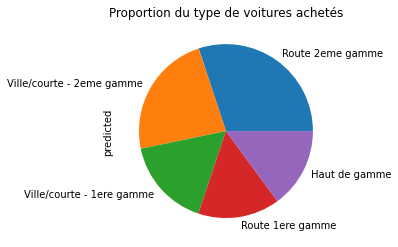

In [5]:
# Test visualisation nombre de ligne par type de voiture
print("Visualisation du type de voiture acheté\n")
total = 0
for t in df_ent_new['predicted'].unique():
    row = df_ent_new[df_ent_new['predicted'] == t].shape[0]
    print (t, ':', row, '=', "{:.2f}".format(row  * 100 / df_ent_new.shape[0]), '%')
    total += row

df_ent_new["predicted"].value_counts(normalize=True).plot(kind='pie', title='Proportion du type de voitures achetés')

**ModelSupervise** est une classe qui nous permet d'automatiser l'entrainement de nos modèles.

In [6]:
class ModelSupervise:
    def __init__(self, df_train, df_pred, predVariable):
        self.df_train = df_train 
        self.df_pred = df_pred 
        self.predVariable = predVariable 

    # list des noms de colonnes du df de prediction
    def get_feature_cols_pred(self):
        return list(self.df_pred.columns)

    # list des noms de colonnes du df d'entrainement   
    def get_feature_cols_train(self):
        return list(self.df_train.columns)
    
    def get_feature_cols_dum_pred(self):
        feature_cols = self.get_feature_cols_pred()
        X_dum = pd.get_dummies(self.df_pred[feature_cols])
        return list(X_dum.columns)
        
    def get_feature_cols_dum_train(self):
        feature_cols = self.get_feature_cols_train()
        X_dum = pd.get_dummies(self.df_train[feature_cols])
        return list(X_dum.columns)

    def create_data_train_test(self, test_size=0.3, random_state=1):
        feature_cols = self.get_feature_cols_pred()
        feature_cols_dum_pred =  self.get_feature_cols_dum_pred()

        X_dum = pd.get_dummies(self.df_train[feature_cols])
        X = X_dum[feature_cols_dum_pred] # Features
        y = self.df_train[self.predVariable] # Target variable
        return train_test_split(X, y, test_size=test_size, random_state=random_state) # 70% training and 30% test

    # return model and accuracy
    def trainModel(self, model):
        # Train Decision Tree Classifer
        X_train, X_test, y_train, y_test = self.create_data_train_test()
        model_train = model.fit(X_train,y_train)
        #Predict the response for test dataset
        y_pred = model_train.predict(X_test)
        accuracy = model_train.score(X_test, y_test) # ou metrics.accuracy_score(y_test, y_pred)
        return model_train, accuracy

# Entrainement des modèles
Nous allons entrainer les classifier suivants :
*  Arbre de décision
*  Random Forrest
*  Bayes
*  KNeighbors

Nous sélectionnerons le meilleur en fonction de leurs résultats.

In [7]:
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Random Forest
from sklearn.naive_bayes import BernoulliNB # bayenne naive
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

m1 = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=12,\
                             min_samples_split=0.004, min_samples_leaf=0.003,
                             random_state=1
                            )
m2 = RandomForestClassifier(bootstrap=True, n_estimators=20, criterion='gini', max_depth=12,\
                                 min_samples_split=0.00041, min_samples_leaf=0.0006, random_state=1)
m3 = BernoulliNB()

m4 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

models = [{'model': m1, 'name': 'ArbreDecision'}, 
          {'model': m2, 'name': 'RandomForest'}, 
          {'model': m3, 'name': 'Bayes'}, 
          {'model': m4, 'name': 'KNeighbors'},
          ]
df_market_type = df_market.copy()
confusion_matrix_array = []
label_conf = ['Ville/courte - 1ere gamme',
              'Ville/courte - 2eme gamme',
              'Route 1ere gamme',
              'Route 2eme gamme',
              'Haut de gamme',
              ]
label_DF = ['VilleCourte1G',
            'VilleCourte2G',
            'Route1G',
            'Route2G',
            'Haut de gamme',
            ]
# ENTRAINEMENT VOITURES NEUVES
for m in models:
    modelSup = ModelSupervise(df_ent_new, df_market, 'predicted')
    X_train, X_test, y_train, y_test = modelSup.create_data_train_test()
    clf = m['model'].fit(X_train,y_train)
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
  
    clf, accuracy = modelSup.trainModel(m['model'])
    accuracy = metrics.accuracy_score(y_test, y_pred) 
    print (m['name'],'accuracy', accuracy * 100)

    # cm = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='true', labels=label_conf) * 100, columns=label_DF, index=label_DF)
    cm = (y_test, y_pred)
    confusion_matrix_array.append(cm)
    # prediction du fichier marketing 
    X_market_dum = pd.get_dummies(df_market)
    market_pred = clf.predict(X_market_dum)
    df_market_type.insert(len(df_market_type.columns), 'predType_new' + m['name'], market_pred)

# ENTRAINEMENT VOITURES OCCASIONS
for m in models:
    modelSup = ModelSupervise(df_ent_occ, df_market, 'predicted')
    X_train, X_test, y_train, y_test = modelSup.create_data_train_test()
    clf = m['model'].fit(X_train,y_train)
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
  
    clf, accuracy = modelSup.trainModel(m['model'])
    accuracy = metrics.accuracy_score(y_test, y_pred) 
    print (m['name'],'accuracy_occ', accuracy * 100)

    cm = (y_test, y_pred)
    confusion_matrix_array.append(cm)
    # prediction du fichier marketing 
    X_market_dum = pd.get_dummies(df_market)
    market_pred = clf.predict(X_market_dum)
    df_market_type.insert(len(df_market_type.columns), 'predType_occ' + m['name'], market_pred)

ArbreDecision accuracy 80.91449235377581
RandomForest accuracy 81.07756582058963
Bayes accuracy 48.88952388459719
KNeighbors accuracy 90.30821377896893
ArbreDecision accuracy_occ 80.96806810398252
RandomForest accuracy_occ 81.41383171879927
Bayes accuracy_occ 51.61072876914881
KNeighbors accuracy_occ 90.95860921752177


Matrice de confusion KNeighbors (voiture Neuves)

In [8]:
from sklearn.metrics import precision_score, recall_score
y_test, y_pred = confusion_matrix_array[3]

label_conf = ['Ville/courte - 1ere gamme',
              'Ville/courte - 2eme gamme',
              'Route 1ere gamme',
              'Route 2eme gamme',
              'Haut de gamme',
              ]
label_DF = ['VilleCourte1G',
            'VilleCourte2G',
            'Route1G',
            'Route2G',
            'Haut de gamme',
            ]

precision = precision_score(y_test, y_pred, average=None, labels=label_conf)
rappel = recall_score(y_test, y_pred, average=None, labels=label_conf)

# label_conf = y_test.unique()
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=label_conf), columns=label_DF, index=label_DF)
cm['Rappel (%)'] = rappel*100
cm.append(pd.DataFrame([precision*100], columns=label_DF, index=['Precision (%)']))

,VilleCourte1G,VilleCourte2G,Route1G,Route2G,Haut de gamme,Rappel (%)
VilleCourte1G,30705.000000,3071.000000,10.000000,13.000000,6.000000,90.829759
VilleCourte2G,2959.000000,43982.000000,14.000000,11.000000,12.000000,93.622547
Route1G,3.000000,14.000000,26946.000000,3826.000000,0.000000,87.518270
Route2G,5.000000,9.000000,4238.000000,54280.000000,2664.000000,88.698608
Haut de gamme,11.000000,3.000000,11.000000,2792.000000,27391.000000,90.674656
Precision (%),91.158745,93.421695,86.312822,89.097535,91.081701,NaN


# Prédiction du fichier Marketing

In [9]:
df_market_final = df_market_type.copy()
df_market_final[cols] = mns.inverse_transform(df_market_final[cols])
df_market_final[['age', 'sexe',	'taux',	'situationFamiliale',	'nbEnfantsAcharge',	'DeuxiemeVoiture',	'predType_newKNeighbors', 'predType_occKNeighbors'	]]\
.rename(columns={"predType_newKNeighbors": "Pred_Voiture_Neuve", "predType_occKNeighbors": "Pred_Voiture_Occasion"})

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,DeuxiemeVoiture,Pred_Voiture_Neuve,Pred_Voiture_Occasion
0,21.0,F,1396.0,Celibataire,0.0,False,Ville/courte - 2eme gamme,Ville/courte - 2eme gamme
1,35.0,M,223.0,Celibataire,0.0,False,Ville/courte - 1ere gamme,Ville/courte - 1ere gamme
2,48.0,M,401.0,Celibataire,0.0,False,Ville/courte - 1ere gamme,Ville/courte - 2eme gamme
3,26.0,F,420.0,En Couple,3.0,True,Route 2eme gamme,Haut de gamme
4,80.0,M,530.0,En Couple,3.0,False,Haut de gamme,Haut de gamme
5,27.0,F,153.0,En Couple,2.0,False,Route 2eme gamme,Route 2eme gamme
6,59.0,F,572.0,En Couple,2.0,False,Route 2eme gamme,Haut de gamme
7,43.0,F,431.0,Celibataire,0.0,False,Ville/courte - 1ere gamme,Ville/courte - 2eme gamme
8,64.0,M,559.0,Celibataire,0.0,False,Ville/courte - 1ere gamme,Ville/courte - 2eme gamme
9,22.0,M,154.0,En Couple,1.0,False,Route 2eme gamme,Route 1ere gamme
